# IBM Quantum Challenges 2021 Ex5

<div align="right">by Howie Kuo</div>


# TL;DR
For those who just want the solution, here are the settings 
* freezeCore = `True`
* orbital removal = `[3,4]`
* mapper = `ParityMapper`
* Ansatz model = `TwoLocal`
    * rotation_blocks = `['rz', 'ry']`
    * entanglement_blocks = `['cx']`
    * entanglement = `'linear'`
    * repetitions = `1`
    * skip_final_rotation_layer = `False`
* Z2 Symmetry reduction `[1,1]`
and here is the code that generate my final ANSATZ

{'pass': True, 'optimizer': 'SLSQP', 'mapping': 'ParityMapper', 'ansatz': 'TwoLocal', 'rotation blocks': ['rz', 'ry'], 'entanglement_blocks': ['cx'], 'entanglement': 'linear', 'repetitions': 1, 'skip_final_rotation_layer': False, 'energy (Ha)': -1.086366954543982, 'error (mHa)': 2.339061190756997, '# of parameters': 16, 'final parameters': array([ 9.99727893e-03,  1.43051797e-01,  1.05232954e-05,  5.25675316e-02,
        3.13162456e+00,  3.19040528e+00,  4.44287688e-01,  9.99777522e-03,
        9.99575704e-03,  9.99669373e-03,  2.52352043e-01, -5.66653828e-03,
       -3.14157238e+00, -2.69653280e+00, -6.87100383e-02,  7.43677103e-02]), '# of evaluations': 905, 'optimizer time': 7.71733546257019, '# of qubits': 4, '# of CNOTs': 3, 'score': 3}


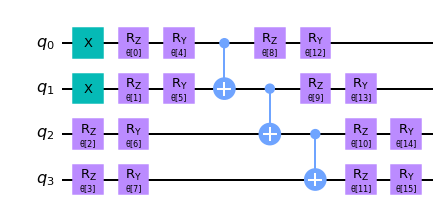

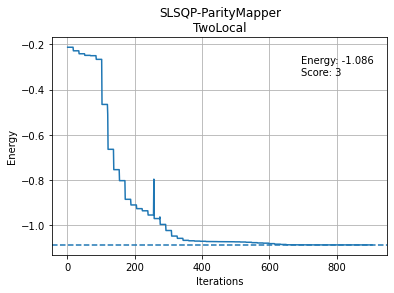

In [1]:
from qiskit_nature.drivers import PySCFDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers import FreezeCoreTransformer
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.algorithms import VQE
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller 
import numpy as np 
from IPython.display import display, clear_output

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
freeze = True 
orbital_removal = [3,4]
two_qubit_reduction = True
z2symmetry_reduction = [1,1]    
backend = Aer.get_backend('statevector_simulator')
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

## create electronics structure problem
freezeT = FreezeCoreTransformer(freeze_core=freeze, remove_orbitals=orbital_removal)
problem = ElectronicStructureProblem(driver, q_molecule_transformers = [freezeT])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

# Setup the mapper and qubit converter
mapper = ParityMapper()

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

converter = QubitConverter(mapper=mapper, 
                           two_qubit_reduction=two_qubit_reduction, 
                           z2symmetry_reduction=z2symmetry_reduction)

qubit_op = converter.convert(main_op, num_particles=num_particles)

init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

rotation_blocks = ['rz', 'ry']
entanglement_blocks = ['cx']
entanglement = 'linear'
repetitions = 1
skip_final_rotation_layer = False
ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                  entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
ansatz.compose(init_state, front=True, inplace=True)

optimizer = SLSQP(maxiter=3000, ftol=1e-10, tol=1e-10) 

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
#print("Exact electronic energy", exact_energy)
#print(result_exact)

counts = []
values = []
params = []
deviation = []
# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std) 

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

## checking and printing information about the ANSATS and VQE result

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value


result_dict = {
    'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
    'optimizer': optimizer.__class__.__name__,
    'mapping': converter.mapper.__class__.__name__,
    'ansatz': ansatz.__class__.__name__,
    'rotation blocks': rotation_blocks,
    'entanglement_blocks': entanglement_blocks,
    'entanglement': entanglement,
    'repetitions': repetitions,
    'skip_final_rotation_layer': skip_final_rotation_layer,
    'energy (Ha)': energy,
    'error (mHa)': (energy-exact_energy)*1000,
    '# of parameters': len(result.optimal_point),
    'final parameters': result.optimal_point,
    '# of evaluations': result.optimizer_evals,
    'optimizer time': result.optimizer_time,
    '# of qubits': int(qubit_op.num_qubits),
    '# of CNOTs': cnots,
    'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')


print(result_dict)
ansatz.draw('mpl')


In [2]:
# Check your answer using following code
from qc_grader import grade_ex5
freeze_core = freeze # change to True if you freezed core electrons
grade_ex5(ansatz,qubit_op,result,freeze_core)

Grading your answer for ex5. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 3.
Feel free to submit your answer.



# What I went through during the Challenge, and some hint and tips

** this section outlines my personal learning process in deciphering the python code. Feel free to skip the beckground and jump directly to the **[Final Challenge](#final_challenge)** section


## 1. Exploring Qiskit 
### 1.1 Read through the background theory

The first thing I did was to explore the Hydrogen example given in the notebook. Personally, I am more of a Python programmer then a Quantum chemist. Hence, I find the python codes easier to understand then the technical blurb in the theory section. So, although I did read the theory section, I did not gain too much useful information on the first pass.


### 1.2 Exploring the code

#### 1.2.1 setting up LiH molecule

The first piece of the code is to specify the $H_2$ molecure and obtain the driver. From reading the code, the first thing I notice is that I need the `qmolecule` object returned from executing `driver.run()`

This is where being familier with Jupyter helps. In jupyter notebook, a very helpful command is the `?` and `??` applied to objects, function, or modules. This will popup a panel at the bottom of the notebook showing the docstring `?`, and the source code `??` from the code in the current system. 


In [3]:
qmolecule?

In [4]:
driver.run?

In [5]:
PySCFDriver?

Now, we have obtained some information about the code:

fact:
1. `PySCDFDriver` have additional parameters that can be tuned. 
2. `qmolecule` contains properties of the molecule.

For tutorial question 1, I had a quick look at the qmolecule object with `??` and the information can be infered from reading the source code and comment of the __init__ function.

In [6]:
qmolecule??

Note: From this point onwards, I am only going to point out the object that I have explored, and the facts I have obtained by source code diving without presenting the details. Just to make the descriptiuon short.

#### 1.2.2 Setting up the Electronic Structure 

Next, the functions to explore are the `ElectronicStructureProblem` and `second_q_ops`

In [7]:
ElectronicStructureProblem??

fact:
1. `PySCDFDriver` have additional parameters that can be tuned.
2. `qmolecule` contains properties of the molecule.
3. `ElectronicsStructureProblem` takes a second parameter of the class `qiskit_nature.transformers.base_transformer.BaseTransformer`
4. `second_q_ops` returns a list and it appears that the code only interested in the first element. (from the comment in the source code, the first in the list is something called 'electronic operator'

Now, we come to the qubit converter section. Which echos some of the confusing terminologies read in the theory section and I start to think that some of these will be important to solving the challenge. 

I take note that there are two important object introduced here, the mappers and converters. 

#### Assumption:
1. converter and mappers are important parameter to tune.

Firstly, lets check out the `ParityMapper`, and then the other two that are in the code but not used for Hydrogen.

In [8]:
ParityMapper?

In [9]:
JordanWignerMapper?

In [10]:
BravyiKitaevMapper?

When I go through the documentation, I took note that these all takes a parameter named `allows_two_qubit_reduction` and there are no much difference in the documentation other then the name.

Next, we take a look at the converter.

In [11]:
QubitConverter?

When I get to look into the document for the converter, I noted that there is another `two_qubit_reduction` parameter and another `z2symmetry_reduction`. which I happily added to my fact list. Note that there was an `allow_two_qubit_reduction` flag in the Mapper.

fact:
1. `PySCDFDriver` have additional parameters that can be tuned.
2. `qmolecule` contains properties of the molecule.
3. `ElectronicsStructureProblem` takes a second parameter of the class `qiskit_nature.transformers.base_transformer.BaseTransformer`
4. `second_q_ops` returns a list and it appears that the code only interested in the first element. (from the comment in the source code, the first in the list is something called 'electronic operator'
5. `Mapper` looks very similar to each other but only ParityMapper have `allow_two_qubit_reduction = True`
6. `QubitConverter` takes another parameter named `two_qubit_reduction`
7. `QubitConverter` has a parameter named `z2symmetry_reduction`

I was a bit confused about the two_qubit_reduction flag appearing in two places. With a bit of code diving, I made the following assumption:

* two_qubit_reduction is a technique for reduce the ansatz size, but it is only allowed with the ParityMapper, hence only ParityMapper set it to true in the __init__ function of the parent class FermionicOperator. And, the process of removing the two qubits are done in the subsequent converter.

#### 1.2.3 HartreeFock 

Next, I did the same with `HartreeFock` function and also note that how the property of the molecule are used to provide the parameters for some of these function. This is just for setting up the initial conditions and lt appear to be a parameter not to be changed by looking ahead into the problem statement.

In [12]:
HartreeFock?

#### 1.2.4 ANSATZ
When I read this part of the code, I immediately assumed that this is the place where all the tuning parameters are. (hindsight: Mapper and converter is where all the tuning happens initially) In summary, these are the additional information obtained.

fact:
1. `PySCDFDriver` have additional parameters that can be tuned.
2. `qmolecule` contains properties of the molecule.
3. `ElectronicsStructureProblem` takes a second parameter of the class `qiskit_nature.transformers.base_transformer.BaseTransformer`
4. `second_q_ops` returns a list and it appears that the code only interested in the first element. (from the comment in the source code, the first in the list is something called 'electronic operator'
5. `Mapper` looks very similar to each other but only ParityMapper have `allow_two_qubit_reduction = True`
6. `QubitConverter` takes another parameter named `two_qubit_reduction`
7. `QubitConverter` has a parameter named `z2symmetry_reduction`
8. TwoLocal have a lot of parameters with many combinations. Remember to look at the document later.
9. UCCSD, SUCCD, PUCCD are all related, but they have a lot less parameter to tune.

In [13]:
TwoLocal?

In [14]:
UCCSD?

In [15]:
SUCCD?

In [16]:
PUCCD?

I also noted that the UCCSD, SUCCD. PUCCD are all subclass of `UCC`. To me, all of these acronymes do not mean much, but from experience with python, I know that there may be parameters hidden in the parent class. So, I want to find `UCC` and see what I can find. 

In [17]:
from qiskit_nature.circuit.library import UCC

In [18]:
UCC?

Read the documentation of UCC and I amd thinking to myself, jackpot. The plan of attack start to become clear. 
1. create the equivelent code for the LiH molecule. 
2. investigate the set of parameters found hidden in UCC, and start to optimise.

<font color='red'>I did not need to explore these parameters at the end. But knowing what's avaliable for tuning is always good.</font> 

#### 1.2.5 the optimisation algorithm

By now, I have spend several hours exploring the code, and finally got to some more familiar terrotory. The four optimizers. Firstly, my attention was drawn to the comment that I might need to change the parameters. BUT, from my experience, these are local optimisers, and there is not much tuning one can do except to reduce the tolerence, or the maximum evaluation or iterations.

Looking into the code, they don't look special and probably comes from the scipy package.

Instead of the default `COBLA`, I switched it to `SLSQP` mostly out of personal familiarity with that algorithm.

In [19]:
# check out the document of the different optimisation algoriths if you need to
#COBYLA?
SLSQP?

#### 1.2.6 Result Checker

Next, we were introduced with another new function `GroundStateEigensolver`. From the documentation, it takes the converter as input, and what appears to be a generic Eigen Solver. 

In [20]:
GroundStateEigensolver??

In [21]:
solver = NumPyMinimumEigensolverFactory()
solver?

Note: usually, sufficient information can be obtained by appending `?` to the end of a function. In the above case, when the function returns a python object, it is more infromative to realise the object and perform the `?` on the object itself to get the information.

Finally, we got to the section of code that execute the `VQE`, and the required argument list do not contain anything that looks like a tuning parameter.

In [22]:
VQE?

Tutorial Question Two asked us to explore all the tunerable parameters and provide the ansatz. Which I skipped.

## Final Challenge<a id='final_challenge'></a>

### Review known information

Combining the fact list obtained above and compare with the checklist we note that there is a hind on the parameters that wee need to tune. That will give us a good starting point to produce an acceptable result and then we can work on beating the best score.

So, here are the important bits. 
1. we need to find the freezeCore Transformer from qiskit_nature.transformers and combine with the finding of fact 3, we can workout how we should use the FreezeCore Transformers.
2. use ParityMapper with two_qubit_reduction=True to eliminate 2 qubits. - looks like we just need to set the flag to true. 
3. use z2Symmetry to reduce the qubits - which we know it is in QubitConverter


In [23]:
from qiskit_nature import transformers
transformers?

Also, it appears that there is another transformer that we can use to further reduce the qubits. (Again, did not need to use this)

In [24]:
transformers.ActiveSpaceTransformer?

## Approach

I pull the code into a function that allows me to quickly explore the various parameters and proceed to find a good enough solution. The function I used is defined in the next cell. 

The defaults in the function are what I considered to be a very conservative starting point, applying only the reductions I am sure to work. And, I set the optimiser to have a very tight tolerence and long maxiter so that I will have a high change of finding a solution dispite a big and long running simulation.

In [25]:
def run(freeze = True, 
        orbital_removal = None, 
        mapper_type = "ParityMapper", 
        ansatz_type = 'TwoLocal', 
        rotation_blocks = ['rz', 'ry'],
        entanglement_blocks = ['cx'],
        entanglement = 'full',
        optimizer_type = 'SLSQP',
        p_rep = 4,
        two_qubit_reduction = True,
        z2symmetry_reduction = None,  
        skip_final_rotation_layer = False,
        show_plot = True, save_plot=False):

    molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'

    driver = PySCFDriver(atom=molecule)
    qmolecule = driver.run()

    ## create electronics structure problem
    freezeT = FreezeCoreTransformer(freeze_core=True, remove_orbitals=orbital_removal)
    if freeze == True:
        problem = ElectronicStructureProblem(driver, q_molecule_transformers = [freezeT])
    else:
        problem = ElectronicStructureProblem(driver)

    # Generate the second-quantized operators
    second_q_ops = problem.second_q_ops()

    # Hamiltonian
    main_op = second_q_ops[0]

    # Setup the mapper and qubit converter


    if mapper_type == 'ParityMapper':
        mapper = ParityMapper()
    elif mapper_type == 'JordanWignerMapper':
        mapper = JordanWignerMapper()
    elif mapper_type == 'BravyiKitaevMapper':  ## this gives a good starting point
        mapper = BravyiKitaevMapper()

    # The fermionic operators are mapped to qubit operators
    num_particles = (problem.molecule_data_transformed.num_alpha,
                 problem.molecule_data_transformed.num_beta)
    num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

    converter = QubitConverter(mapper=mapper, 
                               two_qubit_reduction=two_qubit_reduction, 
                               z2symmetry_reduction=z2symmetry_reduction)

    qubit_op = converter.convert(main_op, num_particles=num_particles)

    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)


    # print('init_state', init_state)

    # Put arguments for twolocal
    if ansatz_type == "TwoLocal":
        # Single qubit rotations that are placed on all qubits with independent parameters
        rotation_blocks = ['rz', 'ry']
        # Entangling gates
        entanglement_blocks = ['cx']
        # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
        repetitions = p_rep

        ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                          entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
        # Add the initial state
        ansatz.compose(init_state, front=True, inplace=True)
    elif ansatz_type == "UCCSD":
        ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    elif ansatz_type == "PUCCD":
        ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    elif ansatz_type == "SUCCD":
        ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)


    # You may want to tune the parameters 
    # of each optimizer, here the defaults are used
    if optimizer_type == 'COBYLA':
        optimizer = COBYLA(maxiter=3000)
    elif optimizer_type == 'L_BFGS_B':
        optimizer = L_BFGS_B(maxfun=500)
    elif optimizer_type == 'SPSA':
        optimizer = SPSA(maxiter=500)
    elif optimizer_type == 'SLSQP':
        optimizer = SLSQP(maxiter=3000, ftol=1e-10, tol=1e-10) 

    # result_exact = exact_diagonalizer(problem, converter)
    exact_energy = -1.089
    #print("Exact electronic energy", exact_energy)
    #print(result_exact)

    counts = []
    values = []
    params = []
    deviation = []
    # Print and save the data in lists
    def callback(eval_count, parameters, mean, std):  
        # Overwrites the same line when printing
        display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
        clear_output(wait=True)
        counts.append(eval_count)
        values.append(mean)
        params.append(parameters)
        deviation.append(std) 

    # Set initial parameters of the ansatz
    # We choose a fixed small displacement 
    # So all participants start from similar starting point
    try:
        initial_point = [0.01] * len(ansatz.ordered_parameters)
    except:
        initial_point = [0.01] * ansatz.num_parameters

    algorithm = VQE(ansatz,
                    optimizer=optimizer,
                    quantum_instance=backend,
                    callback=callback,
                    initial_point=initial_point)

    result = algorithm.compute_minimum_eigenvalue(qubit_op)

    # Unroller transpile your circuit into CNOTs and U gates
    pass_ = Unroller(['u', 'cx'])
    pm = PassManager(pass_)
    ansatz_tp = pm.run(ansatz)
    cnots = ansatz_tp.count_ops()['cx']
    score = cnots

    accuracy_threshold = 4.0 # in mHa
    energy = result.optimal_value

    if ansatz_type == "TwoLocal":
        result_dict = {
            'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
            'optimizer': optimizer.__class__.__name__,
            'mapping': converter.mapper.__class__.__name__,
            'ansatz': ansatz.__class__.__name__,
            'rotation blocks': rotation_blocks,
            'entanglement_blocks': entanglement_blocks,
            'entanglement': entanglement,
            'repetitions': repetitions,
            'skip_final_rotation_layer': skip_final_rotation_layer,
            'energy (Ha)': energy,
            'error (mHa)': (energy-exact_energy)*1000,
            '# of parameters': len(result.optimal_point),
            'final parameters': result.optimal_point,
            '# of evaluations': result.optimizer_evals,
            'optimizer time': result.optimizer_time,
            '# of qubits': int(qubit_op.num_qubits),
            '# of CNOTs': cnots,
            'score': score}
    else:
        result_dict = {
            'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
            'optimizer': optimizer.__class__.__name__,
            'mapping': converter.mapper.__class__.__name__,
            'ansatz': ansatz.__class__.__name__,
            'rotation blocks': None,
            'entanglement_blocks': None,
            'entanglement': None,
            'repetitions': None,
            'skip_final_rotation_layer': None,
            'energy (Ha)': energy,
            'error (mHa)': (energy-exact_energy)*1000,
            '# of parameters': len(result.optimal_point),
            'final parameters': result.optimal_point,
            '# of evaluations': result.optimizer_evals,
            'optimizer time': result.optimizer_time,
            '# of qubits': int(qubit_op.num_qubits),
            '# of CNOTs': cnots,
            'score': score}
    if show_plot:
        # Plot the results
        import matplotlib.pyplot as plt

        fig, ax = plt.subplots(1, 1)
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Energy')
        ax.grid()
        fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
        plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
        ax.plot(counts, values)
        ax.axhline(exact_energy, linestyle='--')
    if save_plot:    
        fig_title = f"\
        {result_dict['optimizer']}-\
        {result_dict['mapping']}-\
        {result_dict['ansatz']}-\
        Energy({result_dict['energy (Ha)']:.3f})-\
        Score({result_dict['score']:.0f})\
        .png"
        fig.savefig(fig_title, dpi=300)

    return(result_dict, ansatz)
    

we start with `freezeCore`, `two_qubit_reduction`. These values/setting are recommended in previous reference materials. For the other parameters I set them to what I think are safe values.

pass: False ;  error (mHa) 18.39972281958846


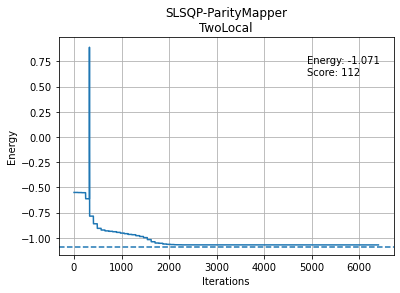

In [26]:
[r,a] = run()
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])

Noting that the final energy error is close but not good enough, I start to explore different ansatz type thinking that it will improve things. And ... indeed we got a pass. 

pass: True ;  error (mHa) -0.7823963464594907
CNOTS: 1276


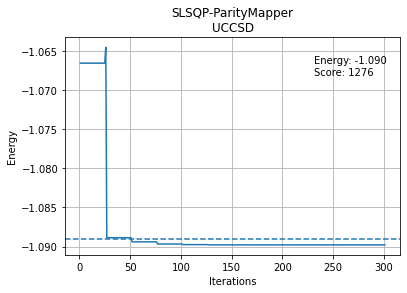

In [27]:
[r,a] = run(ansatz_type = 'UCCSD')
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
print('CNOTS:', r['score'])

And look at the energy error! But the number of CNOT is not acceptable. But progress.

Remember that we have two other variants of ansats to try, and also noting that the optimizer seems to be working better with these.

pass: True ;  error (mHa) 1.4153880269276442
CNOTS: 760


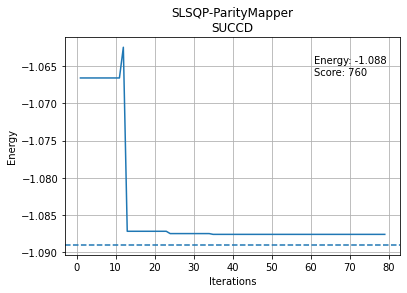

In [28]:
[r,a] = run(ansatz_type = 'SUCCD')
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
print('CNOTS:', r['score'])

Now, we are looking better.

pass: True ;  error (mHa) 3.2658883714065112
CNOTS: 304


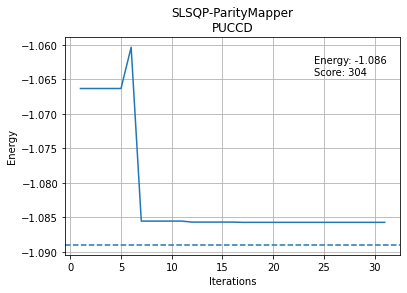

In [29]:
[r,a] = run(ansatz_type = 'PUCCD')
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
print('CNOTS:', r['score'])

And we are just a bit off the acceptable energy here. But noting that PUCCD has the smallest number of qubuts.

#### z2Symmetry

Recalling the documentation from z2Symmetry from `QubitConverter` that it can be 'auto' or a list of 1 or -1. The obvious thing is to try 'auto' but we get an error message. next, I tries a list with 1 element, 2, etc and find that it appear to be doing something with 2 elements. no more no less. 

Staying with 'SUCCD' ansats, I then tries `[1,1]`, `[1,-1]`, `[-1,-1]`, `[-1,1]`

There is little logic here, just bruteforcing. And the best solution 1s `[1,1]`



pass: True ;  error (mHa) 1.4153880361931215
CNOTS: 334


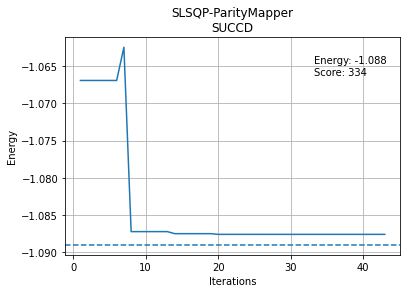

In [30]:
[r,a] = run(ansatz_type = 'SUCCD', z2symmetry_reduction = [1,1])
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
print('CNOTS:', r['score'])

This gives me the first submittable answer. and I take note of the acceptable energy as well as I have found that it is possible to have the answer rejected by the grader that shows a pass in the result when the exact energy calculation are off. I did not bother to remove the exact eigen solver and hardcode the acceptence criteria, but that can be easily done. I simply take note when the energy was off.

Now, the next step is somple. Remember that 'PUCCD' got close last time, lets try our luck there.

pass: True ;  error (mHa) 3.2658883714085096
CNOTS: 254


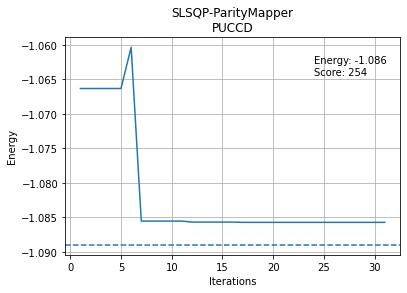

In [31]:
[r,a] = run(ansatz_type = 'PUCCD', z2symmetry_reduction = [1,1])
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
print('CNOTS:', r['score'])

Now, noting that this gives the same error as without z2symmetry_reduction, I tries the other three settings [0,-1], ... etc just to make sure. By now, I also noticed the optimisaer can find the solution really quick. Probably because of the z2symmetry.

pass: False ;  error (mHa) 487.6087956454795
CNOTS: 254


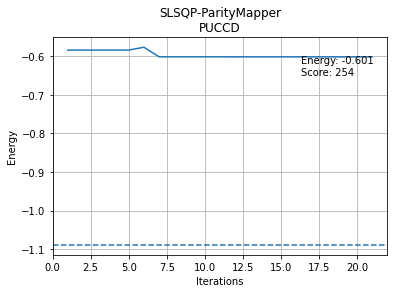

In [32]:
[r,a] = run(ansatz_type = 'PUCCD', z2symmetry_reduction = [-1,-1])
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
print('CNOTS:', r['score'])

pass: False ;  error (mHa) 594.5045264682252
CNOTS: 182


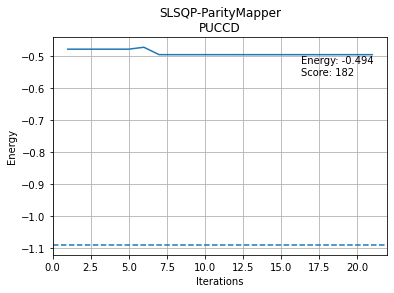

In [33]:
[r,a] = run(ansatz_type = 'PUCCD', z2symmetry_reduction = [1,-1])
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
print('CNOTS:', r['score'])

pass: False ;  error (mHa) 487.6087956454604
CNOTS: 254


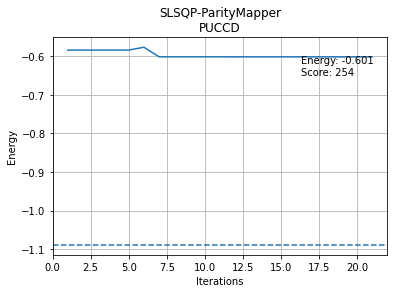

In [34]:
[r,a] = run(ansatz_type = 'PUCCD', z2symmetry_reduction = [-1,1])
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
print('CNOTS:', r['score'])

with the above three fails, I am somewhat convinced that z2Symmetry has to be [1,1] as all other setting are just way off.

Also, note that we are down to 6 qubits, and we still have not used orbital removal. 

So now, is the time to remove orbits. With a list specifying which orbit to remove. 

Firstly, how many orbits did we have? didn't we see a question that ask us about finding the property of the molecules? 

This was my answer to the first tutorial question but applied to the LiH molecure.

In [35]:
n_el = qmolecule.num_alpha + qmolecule.num_beta
n_mo = qmolecule.num_molecular_orbitals
n_so = 2 * qmolecule.num_molecular_orbitals
n_q = 2* qmolecule.num_molecular_orbitals
e_nn = qmolecule.nuclear_repulsion_energy
print(n_el, n_mo, n_so, n_q, e_nn)

4 6 12 12 1.0259348796432726


so, 6 orbits, and let me try removing the last one. Perhaps there is some logic in the ordering... and note the intentional error.

In [36]:
[r,a] = run(ansatz_type = 'SUCCD', z2symmetry_reduction = [-1,-1], orbital_removal = [6])
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
print('CNOTS:', r['score'])

IndexError: index 6 is out of bounds for axis 0 with size 6

now, 6 orbits, indexed 0..5, and the error message confirmed it. so, how many combination? Well, there is a better way.

Lets do 6 experiments, removing one of the six and see which does not break the system.

In [37]:
for i in range(6):
    try:
        [r,a] = run(ansatz_type = 'UCCSD', z2symmetry_reduction = [-1,-1], orbital_removal = [i], show_plot = False, save_plot=False)
        print(i, '  pass:',r['pass'], ';  error (mHa)', r['error (mHa)'], '; energy', 'energy (Ha)')
    except:
        print(i, '  exception')

2   pass: False ;  error (mHa) 188.16685303981652 ; energy energy (Ha)
3   exception
4   exception
5   exception


And we found that we can only remove orbit 2 and the solution does not pass the test.

In [38]:
[r,a] = run(ansatz_type = 'UCCSD', z2symmetry_reduction = [-1,-1], orbital_removal = [2], show_plot = False, save_plot=False)

'Evaluation: 24, Energy: -0.9008331469602671, Std: 0.0'

and the energy just do not look correct.

By now, I have getting close to the end of exploring the UCC family of ansats. and still have not found a working orbit removal. So, time to explore the TwoLocal but with the additional optimisation we have found when exploring the UCC families.

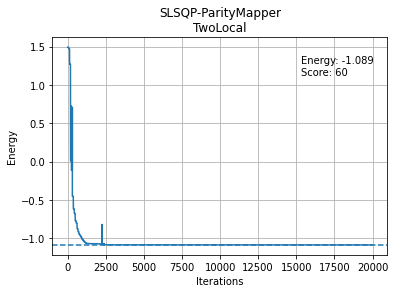

In [39]:
[r,a] = run(freeze = True, 
        mapper_type = "ParityMapper", 
        ansatz_type = 'TwoLocal', 
        entanglement = 'full',
        p_rep=4,
        two_qubit_reduction = True,
        z2symmetry_reduction = [1,1],  
        show_plot = True, 
        save_plot=False)

In [40]:
r

{'pass': True,
 'optimizer': 'SLSQP',
 'mapping': 'ParityMapper',
 'ansatz': 'TwoLocal',
 'rotation blocks': ['rz', 'ry'],
 'entanglement_blocks': ['cx'],
 'entanglement': 'full',
 'repetitions': 4,
 'skip_final_rotation_layer': False,
 'energy (Ha)': -1.0892381212457753,
 'error (mHa)': -0.23812124577538007,
 '# of parameters': 60,
 'final parameters': array([ 9.87417975e-03, -2.11244925e-01, -7.57314155e-02,  8.39746402e-03,
        -4.74779310e-04, -3.18291623e-05,  2.09755782e-06,  2.06535882e-06,
        -6.39371451e-06, -1.33102011e-02, -5.08981859e-04,  1.00079357e-02,
        -1.36832450e-03,  4.58372295e+00,  4.89634935e-02,  6.91198146e-02,
        -1.57361426e-02, -5.26138792e-04,  3.21299196e-05, -3.09995368e-07,
         6.35239474e-08, -1.92456766e-06,  1.00515578e-02,  1.61496855e+00,
         1.08558904e+00, -2.55807944e-01, -4.38295564e-03,  2.50060942e-01,
        -6.93795371e-03, -1.65932099e-02,  2.42610265e-04,  2.04466713e-06,
        -7.33585402e-06,  9.90504789e

Now, progress. The first thing I did was to submit this 60 CNOT Solution before I proceed.

The next obvious parameter to to use 'linear' entanglement because from its name, it will get us the best reduction in the number of CNOTS. And it is much easier then figuring out removing orbits.

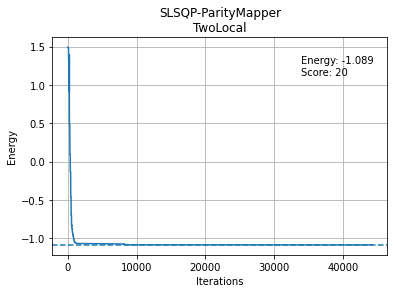

In [41]:
[r,a] = run(freeze = True, 
        mapper_type = "ParityMapper", 
        ansatz_type = 'TwoLocal', 
        entanglement = 'linear',
        p_rep=4,
        two_qubit_reduction = True,
        z2symmetry_reduction = [1,1],  
        show_plot = True, 
        save_plot=False)

In [42]:
r

{'pass': True,
 'optimizer': 'SLSQP',
 'mapping': 'ParityMapper',
 'ansatz': 'TwoLocal',
 'rotation blocks': ['rz', 'ry'],
 'entanglement_blocks': ['cx'],
 'entanglement': 'linear',
 'repetitions': 4,
 'skip_final_rotation_layer': False,
 'energy (Ha)': -1.0891248292016003,
 'error (mHa)': -0.12482920160028499,
 '# of parameters': 60,
 'final parameters': array([ 8.07543209e-03, -1.56405932e+00, -1.57075010e+00,  9.62235425e-01,
        -2.81667192e+00,  3.00875785e+00, -3.48073463e-04, -2.33215964e-03,
        -5.34611292e-06,  1.13268897e+00, -1.93538383e+00,  7.95993093e-03,
        -2.88681637e-01, -2.46250360e-02, -2.94554064e-01, -7.31526793e-05,
         5.48419155e-01,  7.85273939e-03,  2.06486081e-03,  2.81161832e-03,
        -5.54351393e-04, -5.19908852e-06,  9.76858913e-03, -2.05804247e-01,
         1.35490562e-01,  1.71735110e+00,  1.62069354e-01,  2.81414641e-02,
        -2.56275504e-04, -1.08088703e+00,  6.82136835e-02,  1.13729690e-01,
        -2.32915523e-03,  9.6172719

Next, I reduce the repeats and note that it gives acceptable answer at repeat 3

In [43]:
msg = ''
for repeat in [3,2,1]:
    [r,a] = run(freeze = True, 
            mapper_type = "ParityMapper", 
            ansatz_type = 'TwoLocal', 
            entanglement = 'linear',
            p_rep=repeat,
            two_qubit_reduction = True,
            z2symmetry_reduction = [1,1],  
            show_plot = False, 
            save_plot=False)
    msg = msg + "%d pass: %s\n"%(repeat, r['pass'])
    
print(msg)

3 pass: True
2 pass: True
1 pass: False



Finally, I tackle the orbital_removal again, but this time, using the TwoLocal Ansatz. Note that while I am experimenting with the orbital reduction, z2symmetry produce an error message on the size, so I simply modify it to just 1 element.

In [49]:
msg = ''
for o in [0,1,2,3,4,5]:
    try:
        [r,a] = run(freeze = True, 
                orbital_removal = [o],
                mapper_type = "ParityMapper", 
                ansatz_type = 'TwoLocal', 
                entanglement = 'linear',
                p_rep=2,
                two_qubit_reduction = True,
                z2symmetry_reduction = [1,1],  
                show_plot = False, 
                save_plot=False)
        msg += '%d pass: %s\n'%(o, r['pass'])
    except:
        msg += '%d exception\n'%o
print(msg)                              


0 pass: False
1 pass: False
2 pass: True
3 exception
4 exception
5 exception



pass: True ;  error (mHa) 3.9719155851598575


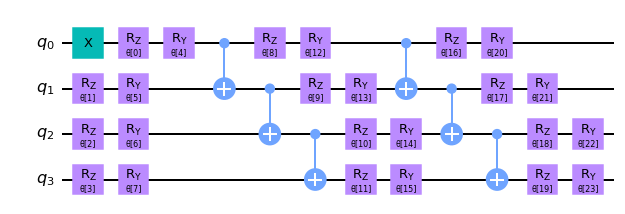

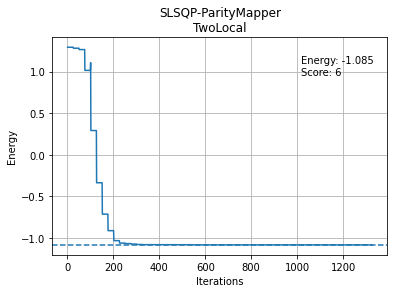

In [55]:
[r,a] = run(freeze = True, 
        orbital_removal = [2], 
        mapper_type = "ParityMapper", 
        ansatz_type = 'TwoLocal', 
        entanglement = 'linear',
        p_rep = 2,
        two_qubit_reduction = True,
        z2symmetry_reduction = [1,1],  
        show_plot = True, 
        save_plot=False)
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
a.draw('mpl')

pass: False ;  error (mHa) 4.01024287578533


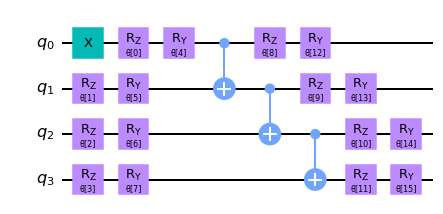

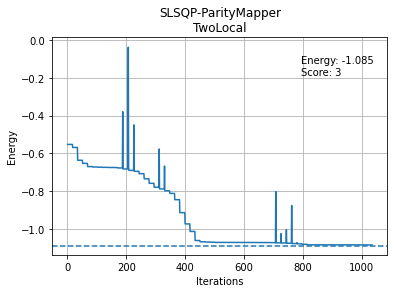

In [56]:
[r,a] = run(freeze = True, 
        orbital_removal = [2], 
        mapper_type = "ParityMapper", 
        ansatz_type = 'TwoLocal', 
        entanglement = 'linear',
        p_rep = 1,
        two_qubit_reduction = True,
        z2symmetry_reduction = [1,1],  
        show_plot = True, 
        save_plot=False)
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
a.draw('mpl')

In [57]:
[r,a] = run(freeze = True, 
        orbital_removal = [3], 
        mapper_type = "ParityMapper", 
        ansatz_type = 'TwoLocal', 
        entanglement = 'linear',
        p_rep = 1,
        two_qubit_reduction = True,
        z2symmetry_reduction = [1,1],  
        show_plot = True, 
        save_plot=False)
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
a.draw('mpl')

QiskitNatureError: 'z2symmetry_reduction tapering values list has invalid length 2 should be 1'

Now, nothing looks right and I start to retrack my steps and see if I missed a turn somewhere. After looking into previous examples, I found that there are two orbits that can be removed, and also, while exploring the error messages, I am guessing that orbit 0, and 1 should be kept or else the initial setup gets messed up. 

So, since there are plenty of time left in the challenge, I will just brute force the orbit reduction pairs.

In [52]:
msg = ''
for o in [[2,3],[2,4],[2,5],[3,3],[3,4],[3,5],[4,5]]:
    try:
        [r,a] = run(freeze = True, 
                orbital_removal = o,
                mapper_type = "ParityMapper", 
                ansatz_type = 'TwoLocal', 
                entanglement = 'linear',
                p_rep=2,
                two_qubit_reduction = True,
                z2symmetry_reduction = [1,1],  
                show_plot = False, 
                save_plot=False)
        msg += '[%d,%d] pass: %s\n'%(o[0], o[1], r['pass'])
    except:
        msg += '[%d,%d] exception\n'%(o[0], o[1])
print(msg)   

[2,3] exception
[2,4] exception
[2,5] exception
[3,3] exception
[3,4] pass: True
[3,5] exception
[4,5] exception



now, look at this! [3,4] lets see what it gives us.

pass: True ;  error (mHa) 0.309432362493256


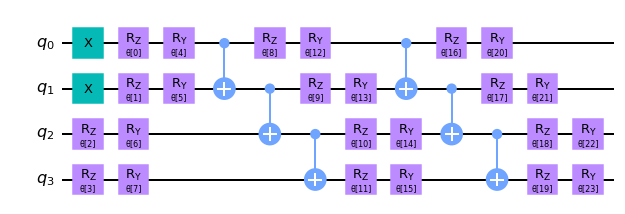

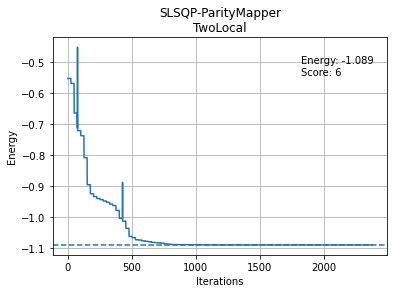

In [58]:
[r,a] = run(freeze = True, 
        orbital_removal = [3,4], 
        mapper_type = "ParityMapper", 
        ansatz_type = 'TwoLocal', 
        entanglement = 'linear',
        p_rep = 2,
        two_qubit_reduction = True,
        z2symmetry_reduction = [1,1],  
        show_plot = True, 
        save_plot=False)
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
a.draw('mpl')

6 CNOTS. And let me remove another repeat to see if it still works.

In [ ]:
[r,a] = run(freeze = True, 
        orbital_removal = [3,4], 
        mapper_type = "ParityMapper", 
        ansatz_type = 'TwoLocal', 
        entanglement = 'linear',
        p_rep = 1,
        two_qubit_reduction = True,
        z2symmetry_reduction = [1,1],  
        show_plot = True, 
        save_plot=False)
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
a.draw('mpl')

'Evaluation: 895, Energy: -1.086366954546917, Std: 0.0'

once we see that orbit 3, and 4 can be removed, we attempt to further reduce the repeats and get our final solution

pass: True ;  error (mHa) 2.633045456425176


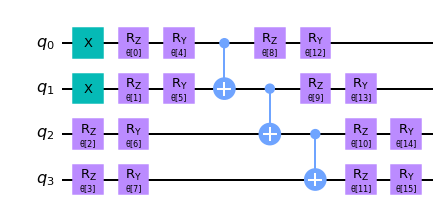

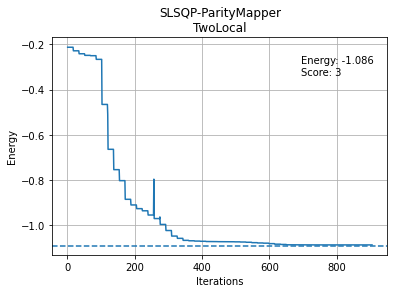

In [48]:
[r,a] = run(freeze = True, 
        orbital_removal = [3,4], 
        mapper_type = "ParityMapper", 
        ansatz_type = 'TwoLocal', 
        entanglement = 'linear',
        p_rep = 1,
        two_qubit_reduction = True,
        z2symmetry_reduction = [1,1],  
        show_plot = True, 
        save_plot=False)
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
a.draw('mpl')

**Thanks** for reading all the way to the end of this lengthy notebook. Hope that you have learned something new. 